In [1]:
import sys
from pathlib import Path

lib_path: str = (Path.cwd().parents[1] / "lib").as_posix()
if lib_path not in sys.path:
    sys.path.insert(1, lib_path)

In [2]:
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from Evaluator import Evaluator
from pathlib import Path

In [3]:
class AttributeDict(dict):
    def __getattr__(self, attr):
        return self[attr]

    def __setattr__(self, attr, value):
        self[attr] = value

# Usage
ROOT_DIR = Path.cwd().parent / "data" / "owl2vec"
FLAGS = AttributeDict()
FLAGS['train_file'] =  ROOT_DIR / "train.csv"
FLAGS['valid_file'] =  ROOT_DIR / "valid.csv"
FLAGS['test_file'] =  ROOT_DIR / "test.csv"
FLAGS['class_file'] =  ROOT_DIR / "classes.txt"
FLAGS['inferred_ancestor_file'] =  ROOT_DIR / "inferred_ancestors.txt"
FLAGS["input_type"] ="concatenate"

In [4]:
TRAIN_PATH = Path.cwd().parent / 'data' / 'FoodOn' /'train_dataset.tsv'
# MODEL_PATH = Path.cwd() / "save_owl2vec_weights" / "OWL2VEC.csv"
MODEL_PATH = Path.cwd() / 'save_pykeen_weights' / 'transF_pykeen_weights.pkl'
CACHEPATH = Path.cwd() / "cache" / (MODEL_PATH.stem + "_cache.pkl")

# Save and Load

In [5]:
owl2vec = MODEL_PATH.parent.name == "save_owl2vec_weights"
if owl2vec:
    classes = [line.strip() for line in open(FLAGS.class_file).readlines()]
    classes_dict = {cls: i for i, cls in enumerate(classes)}
    with open(MODEL_PATH, "rb") as file:
        info = pickle.load(file)
        classes_e = info["classes_e"].to_numpy()
        model_config = info["model_config"]
else:
    with open(MODEL_PATH, "rb") as file:
        info = pickle.load(file)
    classes_dict = info["entities_to_id"]
    classes_e = info["embedded_vectors"]
    classes = list(classes_dict.keys())
    model_config = info["config"]

In [6]:
triples = pd.read_csv(TRAIN_PATH, header=None, names=['head', 'relation', 'tail'])

new_embedsize = classes_e[0].shape[0]
candidate_num = len(classes)

# 2.Train and test

In [7]:
train_samples = [line.strip().split(',') for line in open(FLAGS.train_file).readlines()]
valid_samples = [line.strip().split(',') for line in open(FLAGS.valid_file).readlines()]
test_samples = [line.strip().split(',') for line in open(FLAGS.test_file).readlines()]
random.shuffle(train_samples)



In [8]:
train_x_list, train_y_list = list(), list()
for s in tqdm(train_samples):
    sub, sup, label = s[0], s[1], s[2]
    sub_v = classes_e[classes_dict[sub]]
    sup_v = classes_e[classes_dict[sup]]
    if not (np.all(sub_v == 0) or np.all(sup_v == 0)):
        if FLAGS.input_type == 'concatenate':
            train_x_list.append(np.concatenate((sub_v, sup_v)))
        else:
            train_x_list.append(sub_v - sup_v)
        train_y_list.append(int(label))
train_X, train_y = np.array(train_x_list), np.array(train_y_list)
print('train_X: %s, train_y: %s' % (str(train_X.shape), str(train_y.shape)))

100%|██████████| 41688/41688 [00:00<00:00, 45392.93it/s]

train_X: (41688, 200), train_y: (41688,)


In [9]:
inferred_ancestors = dict()
with open(FLAGS.inferred_ancestor_file) as f:
    for line in f.readlines():
        all_infer_classes = line.strip().split(',')
        cls = all_infer_classes[0]
        inferred_ancestors[cls] = all_infer_classes

# Concept2Vec

In [10]:
from concept2vec import run_concept2vec_evaluation

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

train_samples_df = pd.DataFrame(train_samples, columns=['individual', 'class', 'label'])
sample_tsne_classes = list(train_samples_df[train_samples_df['label'] == '1']["class"].value_counts().head(10).index)

http://www.w3.org/2002/07/owl#Class    28182
Name: count, dtype: int64
No concepts found


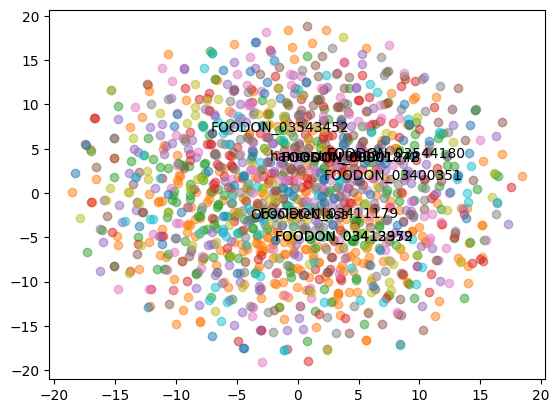

<Figure size 640x480 with 0 Axes>

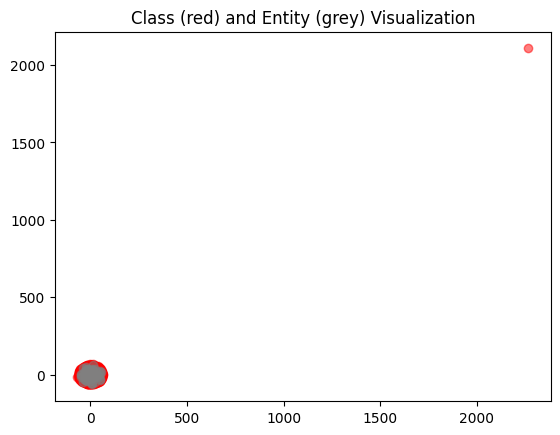

In [11]:
concept_res = run_concept2vec_evaluation(
    triples = triples.values,
    entity_to_id = classes_dict, 
    embedded_vectors = classes_e,
    coherence_top_k = 10,
    train_samples = train_samples,
    tsne_classes = sample_tsne_classes
)

# For Owl2Vec This should get KeyError: 'http://www.w3.org/2002/07/owl#Class' as the owl2vec not save this class with http://www.w3.org/2002/07/owl#ObjectProperty class

# neg-pos distance

In [12]:
from eval_util import run_distance

distance_res = run_distance(
    train_samples = train_samples, 
    embedded_vectors = classes_e, 
    entity_to_id = classes_dict
)

Distance in the embedding space of training samples


  0%|          | 0/41688 [00:00<?, ?it/s]d:\.VScode/projects/Owls2Vec_star/ontology_evaluator/lib\eval_util.py:83: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = average_distance[1] / average_distance[0]
100%|██████████| 41688/41688 [00:01<00:00, 39043.34it/s]

average_distance:
positive: 6.107
negative: 6.921
ratio 0.882


# Semantic-aligned Evaluation

In [13]:
from semantic_eval import SemMR, SemMRR
SEM_DATA_PATH = Path.cwd().parent / 'data' / 'semantic' / 'food_on_filtered_subsumption_dataset.pkl'
with open(SEM_DATA_PATH, "rb") as f:
    testable_dataset = pickle.load(f)

In [14]:
class CacheEvaluator():
    def __init__(self, 
                 CACHEPATH = CACHEPATH
    ):
        self.CACHEPATH = CACHEPATH
        self.load_cache()
    
    def load_cache(self):
        if Path(self.CACHEPATH).exists():
            with open(self.CACHEPATH, 'rb') as f:
                self.cache = pickle.load(f)
        else:
            print(f"Cache file {self.CACHEPATH} not found initializing cache to empty dict")
            self.cache = dict()
    
    def save_cache(self):
        with open(self.CACHEPATH, 'wb') as f:
            pickle.dump(self.cache, f)
            
    def add_to_cache(self, key, value):
        self.cache[key] = value
    
    def get_from_cache(self, key):
        return self.cache.get(key, None)
    
    def evaluate(self, eva_samples, ontology_eva_samples):
        inclusion_metrics = self.inclusion_evaluate(eva_samples)
        ontology_metrics = self.ontology_evaluate(ontology_eva_samples)
        return inclusion_metrics, ontology_metrics
    
    def inclusion_evaluate(self, eva_samples):
        
        MR_sum, MRR_sum, hits1_sum, hits5_sum, hits10_sum = 0, 0, 0, 0, 0
        tqdm_data = tqdm(eva_samples)
        for num, (individual, gt) in enumerate(tqdm_data, start = 1):
            sorted_indexes = self.get_from_cache(individual)
            sorted_classes = list()
            for j in sorted_indexes:
                if classes[j] not in inferred_ancestors[individual]:
                    sorted_classes.append(classes[j])
            rank = sorted_classes.index(gt) + 1
            MR_sum += rank
            MRR_sum += 1.0 / rank
            hits1_sum += 1 if gt in sorted_classes[:1] else 0
            hits5_sum += 1 if gt in sorted_classes[:5] else 0
            hits10_sum += 1 if gt in sorted_classes[:10] else 0
            
            e_MR, e_MRR, hits1, hits5, hits10 = MR_sum/num, MRR_sum/num, hits1_sum/num, hits5_sum/num, hits10_sum/num
            tqdm_data.set_description('MR: %.4f, MRR: %.4f, Hits@1: %.4f, Hits@5: %.4f, Hits@10: %.4f' %
                      (e_MR, e_MRR, hits1, hits5, hits10))
        
        return dict(
            MR = e_MR,
            MRR = e_MRR, 
            hits1 = hits1,
            hits5 = hits5, 
            hits10 = hits10,
        )
    
    def ontology_evaluate(self, ontology_eva_samples):
        tracking_semrr = tracking_semr = 0
        tqdm_data = tqdm(ontology_eva_samples)
        count_in_cache = 0
        for num, data in enumerate(tqdm_data, start = 1):
            sorted_indexes = self.get_from_cache(data[0])
            if sorted_indexes is None:
                continue
            proposed_sequence = [classes[j] for j in sorted_indexes]
            
            semmr = SemMR(proposed_sequence, data[1:])
            semmrr = SemMRR(proposed_sequence, data[1:])
            
            tracking_semrr += semmrr
            tracking_semr += semmr
            count_in_cache += 1
            semr, semrr = tracking_semr/count_in_cache, tracking_semrr/count_in_cache
            tqdm_data.set_description(f"SemMR: {semr:.4f}, SemMRR: {semrr:.4f}")
            
        return dict(
            SemMR = semr,
            SemMRR = semrr,
        )

In [15]:
cache = CacheEvaluator()

Cache file d:\.VScode\projects\Owls2Vec_star\ontology_evaluator\foodon\workspace\cache\transF_pykeen_weights_cache.pkl not found initializing cache to empty dict


In [16]:
class ontologyInclusionEvaluator(Evaluator):
    def __init__(self, valid_samples, test_samples, train_X, train_y):
        super(ontologyInclusionEvaluator, self).__init__(valid_samples, test_samples, train_X, train_y)
    def evaluate(self, model, eva_samples, ontology_eval_samples, mem_limit_GiB = 5):
        print('Evaluating...')
        sample_mem_size = 1_000_000_000 * 8 / (32 * candidate_num * train_X.shape[1])
        array_size_limit = int(mem_limit_GiB * sample_mem_size)
        if array_size_limit < 1:
            raise ValueError(f'Memory limit is too small! at least {1/sample_mem_size:.3f} GiB is required.')
        else:
            print(f'Array size limit: {array_size_limit}')
        MR_sum, MRR_sum, hits1_sum, hits5_sum, hits10_sum = 0, 0, 0, 0, 0
        semmr_sum, semmrr_sum = 0, 0
        tqdm_data = tqdm(range(0, len(eva_samples), array_size_limit), desc='Evaluating...')
        individual_ontology_eval_samples_dict = {sample[0]:i for i, sample in enumerate(ontology_eval_samples)}
        accumulate_total = 0
        ontology_total = 0
        for i in tqdm_data:
            sub_eva_samples = eva_samples[i:min(i + array_size_limit, len(eva_samples))]
            X_array = np.empty((len(sub_eva_samples), candidate_num, train_X.shape[1]), dtype=np.float32)
            for index, (individual, gt) in enumerate(sub_eva_samples):
                sub_index = classes_dict[individual]
                sub_v = classes_e[sub_index]
                if FLAGS.input_type == 'concatenate':
                    X_array[index] = np.concatenate((np.array([sub_v] * candidate_num), classes_e), axis=1)
                else:
                    X_array[index] = np.array([sub_v] * candidate_num) - classes_e
                
            predicted_proba_array = X_array.reshape(-1, train_X.shape[1])
            predicted_proba_array = model.predict_proba(predicted_proba_array)[:, 1].reshape((len(sub_eva_samples), candidate_num))
            for P, (individual, gt) in zip(predicted_proba_array, sub_eva_samples):
                sorted_indexes = np.argsort(P)[::-1]
                cache.add_to_cache(individual, sorted_indexes)
                
                proposed_sequence = [classes[j] for j in sorted_indexes]
                sorted_classes = list()
                for j in sorted_indexes:
                    if classes[j] not in inferred_ancestors[individual]:
                        sorted_classes.append(classes[j])

                rank = sorted_classes.index(gt) + 1
                MR_sum += rank
                MRR_sum += 1.0 / rank
                hits1_sum += 1 if gt in sorted_classes[:1] else 0
                hits5_sum += 1 if gt in sorted_classes[:5] else 0
                hits10_sum += 1 if gt in sorted_classes[:10] else 0
                
                
                # ontology evaluation
                if individual in individual_ontology_eval_samples_dict:
                    ontology_eval_samples_index = individual_ontology_eval_samples_dict[individual]
                    ontology_sequence = ontology_eval_samples[ontology_eval_samples_index][1:]
                    semmr_sum += SemMR(proposed_sequence, ontology_sequence)
                    semmrr_sum += SemMRR(proposed_sequence, ontology_sequence)
                    ontology_total += 1
                
            accumulate_total += len(sub_eva_samples)
            e_MR,e_MRR, hits1, hits5, hits10 = MR_sum / accumulate_total, MRR_sum / accumulate_total, hits1_sum / accumulate_total, hits5_sum / accumulate_total, hits10_sum / accumulate_total
            
            desc = f'Evaluated MR {e_MR:.3f} MRR {e_MRR:.3f}, Hits@1 {hits1:.3f}, Hits@5 {hits5:.3f}, Hits@10 {hits10:.3f}'
            if ontology_total > 0:
                semmr, semmrr = semmr_sum / ontology_total, semmrr_sum / ontology_total
                desc += f', SemMR {semmr:.3f}, SemMRR {semmrr:.3f}'
            tqdm_data.set_description(desc)
        return dict(
            MR = e_MR,
            MRR = e_MRR, 
            hits1 = hits1,
            hits5 = hits5, 
            hits10 = hits10,
            SemMR = semmr,
            SemMRR = semmrr
        )

print("\n		2.Train and test ... \n") # test on test_samples
evaluator = ontologyInclusionEvaluator(None, None, train_X, train_y)
evaluator.run_random_forest()


		2.Train and test ... 



In [17]:
inclusive_res = evaluator.evaluate(evaluator.best_model, test_samples, testable_dataset, mem_limit_GiB = 1)

Evaluating...
Array size limit: 18


Evaluated MR 7727.166 MRR 0.030, Hits@1 0.012, Hits@5 0.041, Hits@10 0.061, SemMR 2996561.890, SemMRR 2.875: 100%|██████████| 331/331 [4:05:38<00:00, 44.53s/it]  


In [18]:
cache.save_cache()

In [19]:
inclusive_res, ontology_res = cache.evaluate(test_samples, testable_dataset)

MR: 7727.1655, MRR: 0.0295, Hits@1: 0.0121, Hits@5: 0.0413, Hits@10: 0.0614: 100%|██████████| 5957/5957 [03:57<00:00, 25.04it/s]
SemMR: 3003744.8987, SemMRR: 2.8805: 100%|██████████| 11392/11392 [00:38<00:00, 294.91it/s]


# save result

In [20]:
from eval_util import Report 
report_man = Report()
all_res = dict(
    inclusive = {**inclusive_res, **ontology_res},
    concept = concept_res,
    distance = distance_res,
)
report_man.save(
    name = MODEL_PATH.stem,
    config = dict(
        eval_config = dict(FLAGS),
        model_config =  model_config
    ),
    res = all_res)
report = report_man.load()

Save file successfully
